In [3]:

import pandas as pd
import numpy as np
import torch

from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.test_functions.multi_fidelity import AugmentedHartmann
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition import PosteriorMean
from botorch.acquisition.knowledge_gradient import qMultiFidelityKnowledgeGradient
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.utils import project_to_target_fidelity
from botorch.acquisition.max_value_entropy_search import qMultiFidelityMaxValueEntropy


problem = AugmentedHartmann(negate=True)

def setUpInitialData(initialSize=5):
    # fidelities = torch.tensor([0.5, 1.0])
    ones = np.full((initialSize,1), 1.0)
    halfs = np.full((initialSize,1), 0.5)
    # generate training data (16 rows with 6 columns.)
    train_x = torch.rand(initialSize, 6)
    # train_f = fidelities[torch.randint(2, (16, 1))]
    # print(train_f)
    train_x_1 = torch.cat((train_x, torch.tensor(ones)), dim=1)
    train_x_half = torch.cat((train_x, torch.tensor(halfs)), dim=1)

    train_obj = problem(train_x_1).unsqueeze(-1)  # add output dimension
    # print(train_obj)
    noise = torch.tensor(np.random.normal(0,0.01,initialSize)).reshape(-1,1)
    obj_with_noise = torch.add(train_obj, noise)
    train_obj = torch.cat((train_obj, obj_with_noise), dim=1).reshape(-1,1)
    train_x_full = torch.cat((train_x_1, train_x_half), dim=0)
    evaluatedList = torch.cat((train_x_full, train_obj), dim=1)
    return train_x_full, train_obj
# define a surrogate model suited for a "training data"-like fidelity parameter
# # in dimension 6, as in [2]
# model = SingleTaskMultiFidelityGP(train_x_full, train_obj, data_fidelity=6)
# mll = ExactMarginalLogLikelihood(model.likelihood, model)


In [4]:

def setUpSampleSize(sampleSize=100):
    sampleSpaceSize = 500
    sampleSpace = torch.rand(sampleSpaceSize, 6)
    sampleOnes = np.full((sampleSpaceSize,1), 1.0)
    sampleHalfs = np.full((sampleSpaceSize,1), 0.5)
    sampleSpace1 = torch.cat((sampleSpace, torch.tensor(sampleOnes)), dim=1)
    sampleSpaceHalf = torch.cat((sampleSpace, torch.tensor(sampleHalfs)), dim=1)
    return  torch.cat((sampleSpace1, sampleSpaceHalf), dim=0)

In [5]:
def runMes(model, Xrpr):
    bounds = torch.tensor([[0.0] * Xrpr.shape[1], [1.0] * Xrpr.shape[1]])
    candidate_set = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(10000, 1)
    target_fidelities = {6: 1.0}
            
    cost_model = AffineFidelityCostModel(fidelity_weights={6: 1.0}, fixed_cost=1.0)
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    acquisition = qMultiFidelityMaxValueEntropy(
            model=model,
            cost_aware_utility=cost_aware_utility,
            project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
            candidate_set=candidate_set,
        )
    acquisitionScores =  acquisition.forward(Xrpr.reshape(-1,1, Xrpr.shape[1]))
    return acquisitionScores

In [6]:
def evaluate(candidate):
    fidelity = candidate[6].item()
    if fidelity == 1.0:
        return  problem(candidate).reshape(-1,1), fidelity
    else:
        detached = candidate.detach().numpy()
        detached[6]=1.0
        output = problem(torch.tensor(detached)).unsqueeze(-1)
        noise = torch.tensor(np.random.normal(0,0.01,1)).reshape(-1,1)
        output_and_noise = torch.add(output, noise)
        return output_and_noise, fidelity

def optimiseAcquisitionFunction(sortedAcqusitionScores, sampleSpaceFull, trainingData):
    def checkFunction(candidate, set):
        for x in set:
            if np.array_equal(candidate, set):
                return True
        return False
            
    for i in range(sampleSpaceFull.shape[0]):
        if ~checkFunction(sampleSpaceFull[sortedAcqusitionScores[i]], trainingData):
            return sampleSpaceFull[sortedAcqusitionScores[i]]

In [ ]:
from botorch import fit_gpytorch_mll
torch.set_printoptions(precision=12, sci_mode=False)
cumulative_cost = 0.0
trackers = []
N_ITER = 30
train_x_full, train_obj = setUpInitialData()
sampleSpaceFull = setUpSampleSize()
for i in range(N_ITER):
    model = SingleTaskMultiFidelityGP(train_x_full, train_obj, data_fidelity=6)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)  
    acquisitionScores = runMes(model=model, Xrpr=sampleSpaceFull)
    sorted_acqusition_scores = acquisitionScores.argsort(descending=True)
    top_candidate = optimiseAcquisitionFunction(sorted_acqusition_scores, sampleSpaceFull, train_x_full)
    evaluated_top_candidate, fidelity = evaluate(top_candidate)
    cumulative_cost += fidelity
    train_x_full = torch.cat([train_x_full, top_candidate.unsqueeze(-2)])
    train_obj = torch.cat([train_obj, evaluated_top_candidate])

print(train_x_full)
print(train_obj)
print(cumulative_cost)

In [23]:
#Plot the samples.
import matplotlib.pyplot as plt

def plot(samples, targets, title, colours=['red','blue','green']):
    samples = samples.detach().numpy()
    targets = targets.detach().numpy()
    nb_iterations = len(samples) - 1
    fidelities = list(dict.fromkeys(samples[:, 6]))
    print(fidelities)
    fidelities.sort()
    # maximum_target=[]
    for fidelity in fidelities:
        fidelity_target=[]
        fidelity_iteration=[]
        for i in range(0, nb_iterations):
            if (samples[i,6] == fidelity):
                fidelity_target.append(targets[i])
                fidelity_iteration.append(i)
        # maximum_target.append(max(df_total[df_total['fidelity']==fidelity]['target']))
        legend_text = f'Fidelity: {fidelity}'
        plt.scatter(fidelity_iteration, fidelity_target, label=legend_text, color=colours[fidelities.index(fidelity)])
    # plt.axhline(y=maximum_target[-1], color='black', linestyle='--', label='Global Max for Best Fidelity')
    plt.legend(loc="lower right")
    plt.xlabel("Iteration Number")
    plt.ylabel("Target")
    plt.ylim([min(targets)-1, max(targets)+1])
    plt.title(title)

[1.0, 0.5]


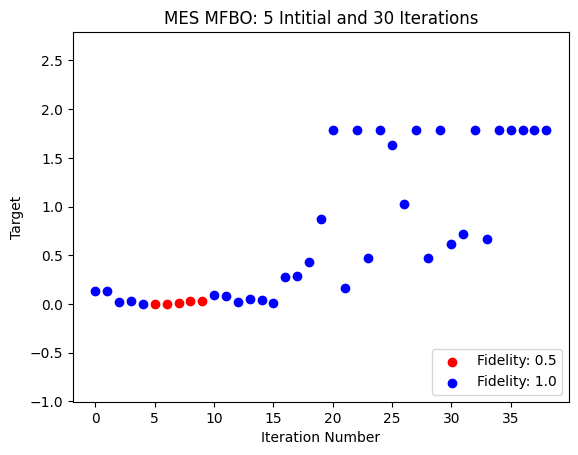

In [24]:
plot(train_x_full, train_obj, 'MES MFBO: 5 Intitial and 30 Iterations')